[Previous: Time series graphics](02-Time-series-graphics.ipynb)
• [Contents](Contents.ipynb)
• [Next: Time series features](04-Time-series-features.ipynb)

# Time Series Decomposition

[FPP3 Chapter 3](https://otexts.com/fpp3/decomposition.html)

* [3.1 Transformations and adjustments](#3.1-Transformations-and-adjustments)
* [3.2 Time series components](#3.2-Time-series-components)
* [3.3 Moving averages](#3.3-Moving-averages)
* [3.4 Classical decomposition](#3.4-Classical-decomposition)
* [3.5 X11 decomposition](#3.5-X11-decomposition)
* [3.6 SEATS decomposition](#3.6-SEATS-decomposition)
* [3.7 STL decomposition](#3.7-STL-decomposition)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

# extra import for interactive plot!
from ipywidgets import interact

[utils.py](utils.py)

## 3.1 Transformations and adjustments

[FPP3 Section 3.1](https://otexts.com/fpp3/transformations.html)

### Calendar adjustments

E.g. account for trading days per month.

### Population adjustments

In [2]:
global_economy = pd.read_csv('data/tsibbledata/global_economy.csv')

In [3]:
global_economy

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
0,Afghanistan,AFG,1960,5.377778e+08,NaN,NaN,7.024793,4.132233,8996351.0
1,Afghanistan,AFG,1961,5.488889e+08,NaN,NaN,8.097166,4.453443,9166764.0
2,Afghanistan,AFG,1962,5.466667e+08,NaN,NaN,9.349593,4.878051,9345868.0
3,Afghanistan,AFG,1963,7.511112e+08,NaN,NaN,16.863910,9.171601,9533954.0
4,Afghanistan,AFG,1964,8.000000e+08,NaN,NaN,18.055555,8.888893,9731361.0
...,...,...,...,...,...,...,...,...,...
15145,Zimbabwe,ZWE,2013,1.909102e+10,1.989493,109.079488,36.668735,21.987759,15054506.0
15146,Zimbabwe,ZWE,2014,1.949552e+10,2.376929,108.847215,33.741470,20.930146,15411675.0
15147,Zimbabwe,ZWE,2015,1.996312e+10,1.779873,106.224541,37.588635,19.160176,15777451.0
15148,Zimbabwe,ZWE,2016,2.054868e+10,0.755869,104.560626,31.275493,19.943532,16150362.0


In [4]:
aus_economy = global_economy.query("Country == 'Australia'").set_index('Year')

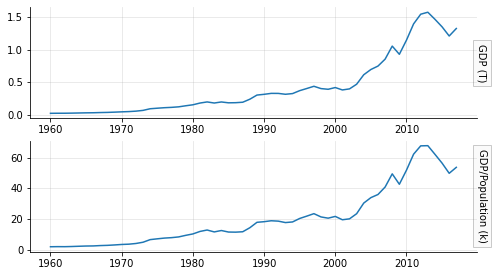

In [5]:
fig, axs = plt.subplots(2)
axs[0].plot(aus_economy.GDP / 1e12)
rlabel(axs[0], 'GDP (T)')
axs[1].plot(aus_economy.GDP / aus_economy.Population / 1e3)
rlabel(axs[1], 'GDP/Population (k)')
for ax in axs:
    ax.grid()

### Inflation adjustments

In [6]:
print_retail = (
    pd.read_csv('data/tsibbledata/aus_retail.csv', parse_dates=['Month'], infer_datetime_format=True)
    .query("Industry == 'Newspaper and book retailing'")
    .pipe(compute, lambda x: dict(Year = x.Month.dt.year))
    .groupby('Industry Year'.split())
    .agg(dict(Turnover=sum))
    .reset_index()
)
print_retail.tail()

,Industry,Year,Turnover
32,Newspaper and book retailing,2014,3648.5
33,Newspaper and book retailing,2015,3333.5
34,Newspaper and book retailing,2016,3206.5
35,Newspaper and book retailing,2017,3156.2
36,Newspaper and book retailing,2018,2914.0


In [7]:
d = (
    print_retail
    .set_index('Year')
    .join(aus_economy)
    .pipe(compute, lambda x: dict(Adjusted_Turnover = x.Turnover/x.CPI))
)

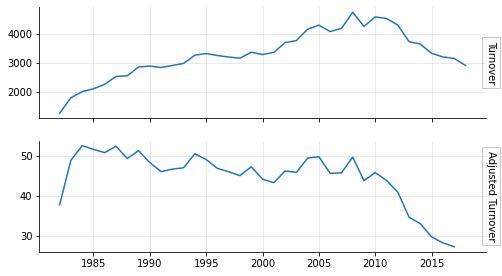

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(d.Turnover)
rlabel(axs[0],'Turnover')
axs[1].plot(d.Adjusted_Turnover)
rlabel(axs[1],'Adjusted Turnover')
for ax in axs:
    ax.grid()

### Mathematical transformations

In [9]:
d = pd.read_csv('data/tsibbledata/aus_production.csv')
aus_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .pipe(compute, lambda x: dict(Year=x.Date.dt.year))
    .set_index('Date')
    .drop(columns='Year'.split())
)

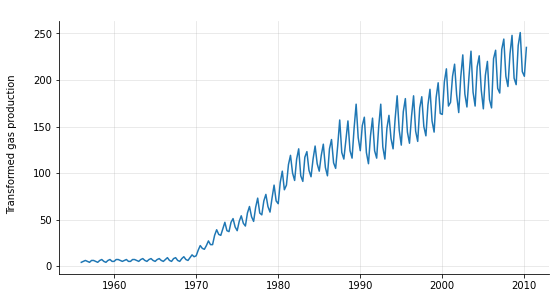

In [10]:
f = lambda lam: stats.boxcox(aus_production.Gas, lam)

@interact(lam=(-1, 2, .1))
def update(lam=1):
    fig, ax = plt.subplots()
    ax.plot(aus_production.index, stats.boxcox(aus_production.Gas, lam))
    ax.set_title(' ')
    fig.text(.01, .5, 'Transformed gas production', rotation=90,
             ha='left', va='center')
    ax.grid()
    fig.subplots_adjust(left=.1, right=.95, bottom=.1)

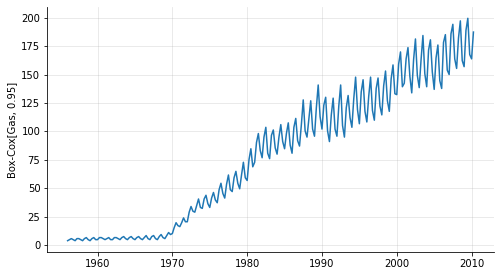

In [11]:
lam = stats.boxcox_normmax(aus_production.Gas)
fig, ax = plt.subplots()
ax.plot(aus_production.index, stats.boxcox(aus_production.Gas, lam))
ax.set(ylabel=f'Box-Cox[Gas, {lam:.2f}]')
ax.grid()

In [12]:
del lam

## 3.2 Time series components

[FPP3 Section 3.2](https://otexts.com/fpp3/components.html)

In [13]:
d = pd.read_csv('data/fpp3/us_employment.csv')
us_retail_employment = (
    d
    .assign(date=pd.to_datetime(d.Month, format='%Y %b'))
    .pipe(compute, lambda x: dict(year=x.date.dt.year))
    .query("year >= 1990 and Title == 'Retail Trade'")
    .set_index('date')
    .drop(columns='year Series_ID'.split())
) 
us_retail_employment

,Month,Title,Employed
date,,,
1990-01-01,1990 Jan,Retail Trade,13255.8
1990-02-01,1990 Feb,Retail Trade,12966.3
1990-03-01,1990 Mar,Retail Trade,12938.2
1990-04-01,1990 Apr,Retail Trade,13012.3
1990-05-01,1990 May,Retail Trade,13108.3
...,...,...,...
2019-05-01,2019 May,Retail Trade,15691.6
2019-06-01,2019 Jun,Retail Trade,15775.5
2019-07-01,2019 Jul,Retail Trade,15785.9


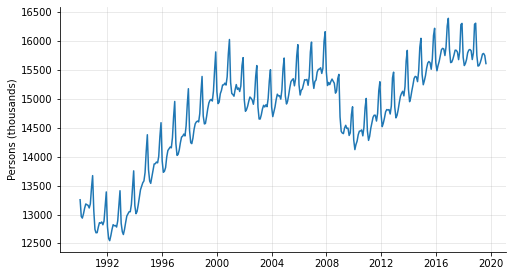

In [14]:
fig, ax = plt.subplots()
ax.plot(us_retail_employment.Employed)
ax.set(ylabel='Persons (thousands)')
ax.grid()

In [15]:
fit = sm.tsa.STL(us_retail_employment.Employed).fit()

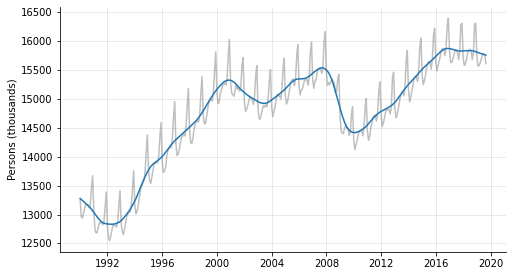

In [16]:
fig, ax = plt.subplots()
ax.plot(us_retail_employment.Employed, color='.5', alpha=.5)
ax.plot(fit.trend)
ax.set(ylabel='Persons (thousands)')
ax.grid()

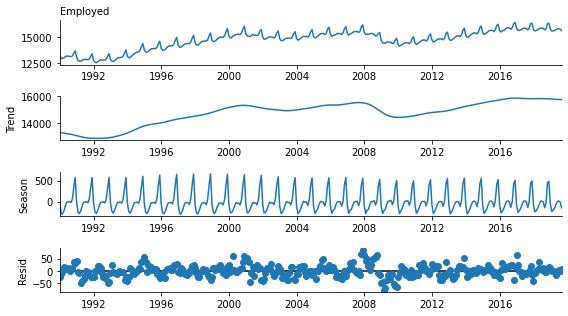

In [17]:
fit.plot();

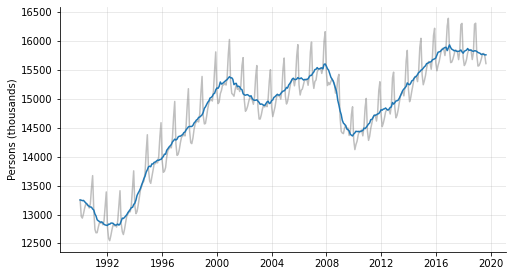

In [18]:
fig, ax = plt.subplots()
ax.plot(us_retail_employment.Employed, color='.5', alpha=.5)
ax.plot(us_retail_employment.Employed - fit.seasonal)
ax.set(ylabel='Persons (thousands)')
ax.grid()

## 3.3 Moving averages

[PFF3 Section 3.3](https://otexts.com/fpp3/moving-averages.html)

### Moving average smoothing

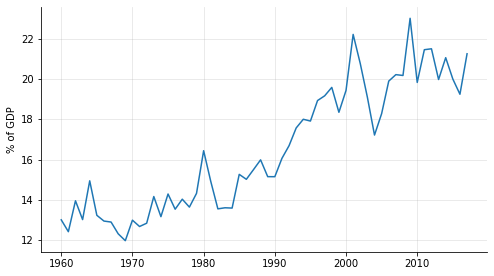

In [19]:
fig, ax = plt.subplots()
ax.plot(aus_economy.Exports)
ax.set(ylabel='% of GDP')
ax.grid()

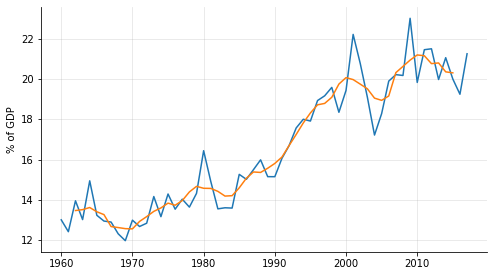

In [20]:
fig, ax = plt.subplots()
ax.plot(aus_economy.Exports)
ax.plot(aus_economy.Exports.rolling(5, center=True).mean())
ax.set(ylabel='% of GDP')
ax.grid()

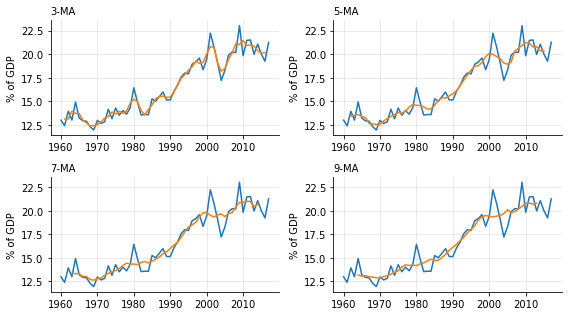

In [21]:
fig, axs = plt.subplots(2, 2)
rolls = 3, 5, 7, 9
for (ax, roll) in zip(axs.ravel(), rolls):
    ax.plot(aus_economy.Exports)
    ax.plot(aus_economy.Exports.rolling(roll, center=True).mean())
    ax.set(ylabel='% of GDP', title=f'{roll}-MA')
    ax.grid()
plt.tight_layout()

### Moving averages of moving averages

In [22]:
(
    aus_production
    .Beer
    .rolling(4, center=True).mean()
    .rolling(2, center=True).mean()
)

Date
1956-01-01        NaN
1956-04-01        NaN
1956-07-01        NaN
1956-10-01    255.250
1957-01-01    254.375
               ...   
2009-04-01    428.875
2009-07-01    430.000
2009-10-01    429.875
2010-01-01    426.750
2010-04-01        NaN
Name: Beer, Length: 218, dtype: float64

### Estimating the trend-cycle with seasonal data

### Example: Employment in the US retail sector

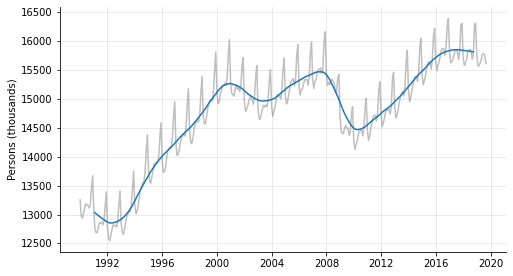

In [23]:
d = us_retail_employment
y = d.Employed.rolling(24, center=True).mean().rolling(2, center=True).mean()

fig, ax = plt.subplots()
ax.plot(d.Employed, color='.5', alpha=.5)
ax.plot(y)
ax.set(ylabel='Persons (thousands)')
ax.grid()

Too small smoothing window $\rightarrow$ trend curve has seasonal fluctuations.

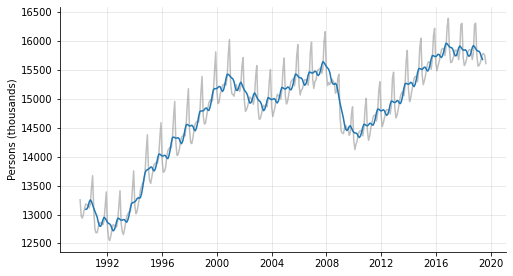

In [24]:
d = us_retail_employment
y = d.Employed.rolling(8, center=True).mean().rolling(2, center=True).mean()

fig, ax = plt.subplots()
ax.plot(d.Employed, color='.5', alpha=.5)
ax.plot(y)
ax.set(ylabel='Persons (thousands)')
ax.grid()

### Weighted moving averages

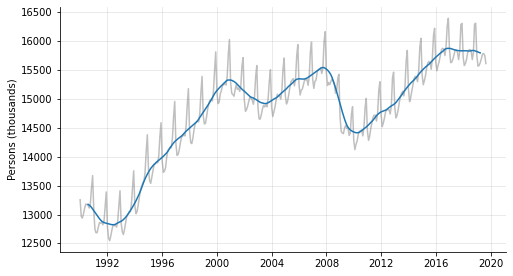

In [25]:
d = us_retail_employment
y = d.Employed.rolling(12, center=True, win_type='gaussian').mean(std=12).rolling(2, center=True).mean()

fig, ax = plt.subplots()
ax.plot(d.Employed, color='.5', alpha=.5)
ax.plot(y)
ax.set(ylabel='Persons (thousands)')
ax.grid()

## 3.4 Classical decomposition

[FPP3 Section 3.4](https://otexts.com/fpp3/classical-decomposition.html)

### Additive decomposition

In [26]:
fit = fit_classical_additive = sm.tsa.seasonal_decompose(us_retail_employment.Employed)

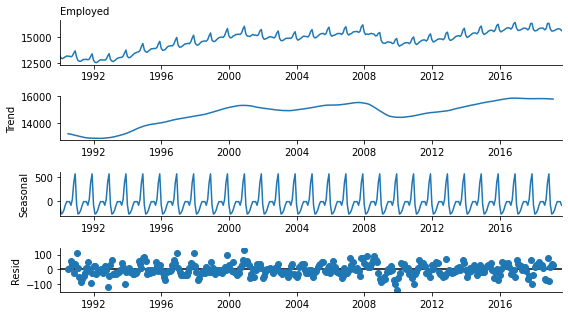

In [27]:
fit.plot();

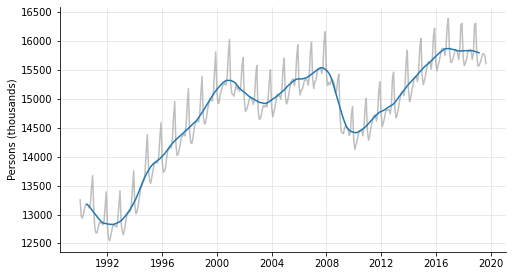

In [28]:
fig, ax = plt.subplots()
ax.plot(d.Employed, color='.5', alpha=.5)
ax.plot(fit.trend)
ax.set(ylabel='Persons (thousands)')
ax.grid()

### Multiplicative decomposition

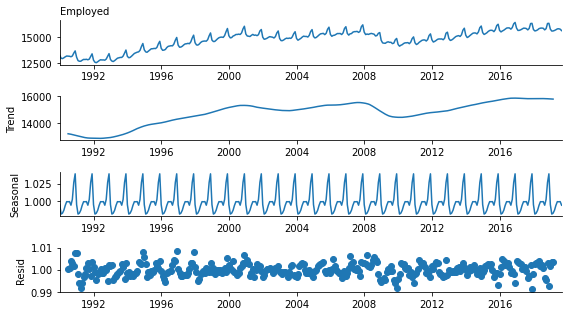

In [29]:
fig = sm.tsa.seasonal_decompose(us_retail_employment.Employed, model='multiplicative').plot()
fig.axes[-1].set(ylim=(.99, 1.01));

### Comments on classical decomposition

## 3.5 X11 decomposition

[FPP3 Section 3.5](https://otexts.com/fpp3/x11.html)

TODO: is `extrapolate_trend` doing X11?

Seems not to be.

In [30]:
fit = sm.tsa.seasonal_decompose(
    us_retail_employment.Employed,
    extrapolate_trend=10)

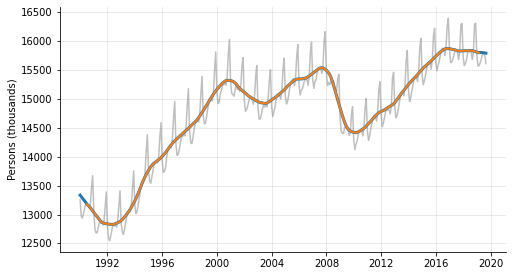

In [31]:
fig, ax = plt.subplots()
ax.plot(d.Employed, color='.5', alpha=.5)
ax.plot(fit.trend, lw=3)
ax.plot(fit_classical_additive.trend, lw=2)
ax.set(ylabel='Persons (thousands)')
ax.grid()

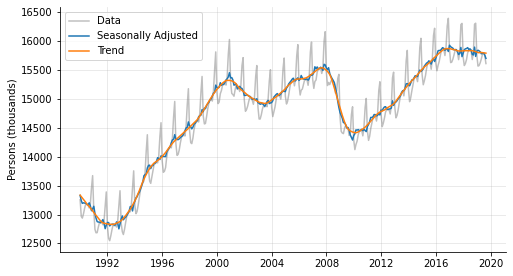

In [32]:
fig, ax = plt.subplots()
ax.plot(d.Employed, color='.5', alpha=.5, label='Data')
ax.plot(d.Employed - fit.seasonal, label='Seasonally Adjusted')
ax.plot(fit.trend, label='Trend')
ax.set(ylabel='Persons (thousands)')
ax.legend()
ax.grid()

In [33]:
d = fit.seasonal.to_frame().reset_index()
d = d.assign(year=d.date.dt.year, month=d.date.dt.month)

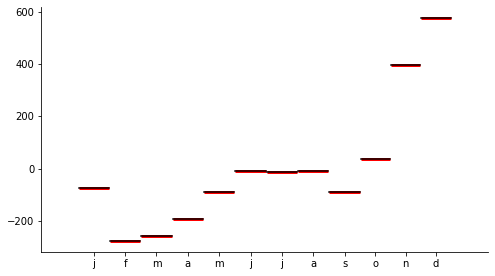

In [34]:
sm.graphics.tsa.month_plot(d.set_index('date').seasonal);

## 3.6 SEATS decomposition

[FPP3 Section 3.6](https://otexts.com/fpp3/seats.html)

In [35]:
Y = us_retail_employment.Employed
Y.index.freq = 'MS'

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


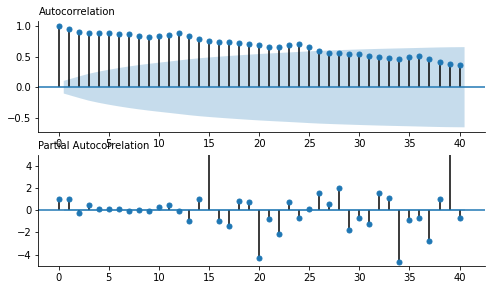

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Y, lags=40, ax=ax2)
ax2.set(ylim=(-5,5));

**TODO:** How to do decomposition?

## 3.7 STL decomposition

Note: no obvious way to match `season(window='periodic')` from R.

In [37]:
fit = sm.tsa.STL(Y).fit()

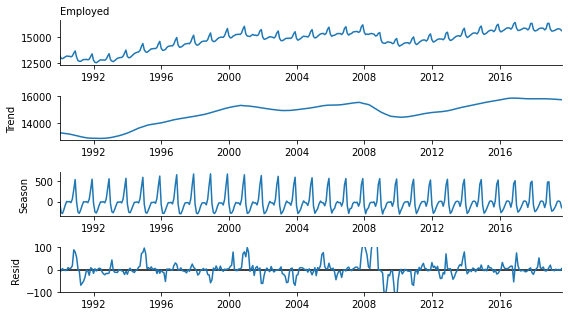

In [38]:
fit = sm.tsa.STL(Y, robust=True, trend=15).fit()
fig = fit.plot()
ax = fig.axes[-1]
ax.lines[0].set(linestyle='-', marker=None)
ax.set(ylim=(-100, 100));

<hr/>

[Previous: Time series graphics](02-Time-series-graphics.ipynb)
• [Contents](Contents.ipynb)
• [Next: Time series features](04-Time-series-features.ipynb)